# Retrieval-Augmented Generation (RAG), Ollama y ChatBots

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ohtar10/icesi-nlp/blob/main/Sesion6/1-ollama-rag.ipynb)

En este notebook exploraremos una implementación simple de un modelo RAG para un corpus de [Wikihow](https://es.wikihow.com/Portada), un popular sitio con tutoriales de todo tipo. Además de eso, exploraremos el uso de [Ollama](https://ollama.com) una librería de reciente salida que facilita enormemente el poder instalar y correr localmente grandes modelos de lenguaje como [Llama 3](https://ai.meta.com/blog/meta-llama-3/) de Meta, el cual utilizarémos como motor de lenguaje base para crear un ChatBot conversacional adaptado al corpus de Wikihow en español.

**Nota:** En este notebook no se realizará el entrenamiento de ningún modelo, se utilizarán modelos pre-entrenados y se combinaran de una forma interesante para hacer uso de cada componente a su modo y crear un agente de conversación


### References
- [Newtral Simple RAG Example](https://github.com/LozanoAlvarezb/MLOPS-Newtral)
- [Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks](http://arxiv.org/abs/2005.11401)
- [Natural Language Processing with Transformers: Building Language Applications With Hugging Face](https://www.amazon.com/Natural-Language-Processing-Transformers-Applications/dp/1098103246)
- [Hugging Face Transformers](https://huggingface.co/docs/transformers/v4.41.3/en/index)

In [1]:
import pkg_resources
import warnings

warnings.filterwarnings('ignore')

installed_packages = [package.key for package in pkg_resources.working_set]
IN_COLAB = 'google-colab' in installed_packages

/tmp/ipython-input-2396000874.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [2]:
#!test '{IN_COLAB}' = 'True' && wget  https://github.com/Ohtar10/icesi-nlp/raw/refs/heads/main/requirements.txt && pip install -r requirements.txt
!test '{IN_COLAB}' = 'True' && sudo apt-get update -y
!test '{IN_COLAB}' = 'True' && sudo apt-get install python3.10 python3.10-distutils python3.10-lib2to3 lshw -y
!test '{IN_COLAB}' = 'True' && sudo update-alternatives --install /usr/local/bin/python python /usr/bin/python3.11 2
!test '{IN_COLAB}' = 'True' && sudo update-alternatives --install /usr/local/bin/python python /usr/bin/python3.10 1
!test '{IN_COLAB}' = 'True' && pip install lightning datasets 'transformers[torch]' sentence-transformers torchinfo evaluate ollama gradio colab-xterm

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,005 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Pa

### Dataset de Wikihow

Este es una traducción por máquina del dataset de Wikihow del popular sitio [www.wikihow.com](https://www.wikihow.com/Main-Page) que publica tutoriales para todo tipo de situaciones y actividades cotidianas.

- https://huggingface.co/datasets/somosnlp/wikihow_es


In [3]:
from datasets import load_dataset

dataset = load_dataset('somosnlp/wikihow_es', split='train')
dataset

README.md:   0%|          | 0.00/912 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/148M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/37.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/90528 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/22632 [00:00<?, ? examples/s]

Dataset({
    features: ['title', 'section_name', 'summary', 'document', 'english_section_name', 'english_url', 'url'],
    num_rows: 90528
})

In [4]:
import pandas as pd

pd.set_option('display.max_colwidth', 100)
dataset.set_format(type='pandas')
df = dataset.to_pandas()
df.head(15)


,title,section_name,summary,document,english_section_name,english_url,url
0,¿Cómo cultivar Delphinium?,Tomar esquejes de delphinium,"Cuando llegue marzo o abril, escoge brotes nuevos cerca de la base de la planta. Haz el corte ce...","Estos brotes serán jóvenes y sólidos, lo que es importante para un esqueje sano. A medida que la...",Taking Delphinium Cuttings,https://www.wikihow.com/Grow-Delphinium,https://es.wikihow.com/cultivar-delphinium
1,¿Cómo elegir Un buen nombre de dominio para tu sitio web?,Pensar en el futuro,Comprométete con el nombre de dominio. Escoge un nombre que deje espacio para el crecimiento. Ev...,"Cualquiera sea el nombre de dominio que escojas, debes asegurarte de comprometerte con este a la...",Thinking About the Future,https://www.wikihow.com/Pick-a-Good-Domain-Name-for-Your-Website,https://es.wikihow.com/elegir-un-buen-nombre-de-dominio-para-tu-sitio-web
2,¿Cómo hacer Tus propios regalos de navidad?,Convierte fotos en regalos,. Toma una fotografía Prueba las fotos personales.,"ecora un marco de fotos. Compra un marco de fotos barato. Puedes usar plástico, pero otros mater...",Turning Photos Into Gifts,https://www.wikihow.com/Make-Your-Own-Christmas-Gifts,https://es.wikihow.com/hacer-tus-propios-regalos-de-Navidad
3,¿Cómo soñar Despierto?,Saber qué soñar,Sueña con tu futuro deseado. Sueña con tus cosas favoritas. Actúa en tus sueños. Sueña con algo ...,Soñar despierto con una meta en mente puede ayudarte a obtener la motivación para alcanzarla. Im...,Knowing What to Dream About,https://www.wikihow.com/Daydream,https://es.wikihow.com/so%C3%B1ar-despierto
4,¿Cómo planear Una fiesta de navidad que sea elegante?,Comidas y bebidas,Debes decidir si vas a servir bebidas alcohólicas en tu fiesta: Los bocadillos y postres son una...,"en caso de hacerlo, debes tener refrescos o ponche para aquellos que no beban alcohol. También e...",Refreshments and Food,https://www.wikihow.com/Plan-an-Elegant-Christmas-Party,https://es.wikihow.com/planear-una-fiesta-de-navidad-que-sea-elegante
5,¿Cómo ver Las descargas en android?,Usar un administrador de archivos,"Abre la bandeja de aplicaciones. Pulsa Descargas, Mis archivos o Administrador de archivos. Sele...","Esta es la lista de aplicaciones del dispositivo Android. Por lo general, puedes abrirla pulsand...",Using a File Manager,https://www.wikihow.com/View-Downloads-on-Android,https://es.wikihow.com/ver-las-descargas-en-Android
6,¿Cómo deshacerse De los insectos de escama?,Eliminar los insectos de escama del jardín,Usa los mismos métodos que los que usaste para las plantas del interior al combatir un ataque de...,Estos insectos son más predominantes al aire libre donde infestan a todas las especies de árbole...,Removing Scales from the Garden,https://www.wikihow.com/Get-Rid-of-Scale-Insects,https://es.wikihow.com/deshacerse-de-los-insectos-de-escama
7,¿Cómo quitar Una mancha de vino tinto de una mesa de madera?,Mancha fresca de vino tinto,Seca el derrame de vino tinto con un paño absorbente húmedo inmediatamente. Usa una toalla suave...,Asegúrate de sólo secar el área; no lo frotes ya que se podría extender en la superficie de made...,Fresh Red Wine Stain,https://www.wikihow.com/Remove-a-Red-Wine-Stain-Ring-from-a-Wood-Table,https://es.wikihow.com/quitar-una-mancha-de-vino-tinto-de-una-mesa-de-madera
8,¿Cómo adiestrar A un gato con un clicker?,Prepárate para entrenar al gato,Consigue un clicker. Ten algunos premios a la mano. Consigue un artículo objetivo. Encuentra un ...,"Un clicker es una caja de plástico pequeña con una pestaña de metal. Al presionarla, produce un ...",Getting Ready to Train Your Cat,https://www.wikihow.com/Clicker-Train-a-Cat,https://es.wikihow.com/adiestrar-a-un-gato-con-un-clicker
9,¿Cómo hacer Un mate pastor en el ajedrez?,Realizar la jugada,Juega con las piezas blancas. e4: Bc4: Qh5: Qxf7: ¡Jaque Mate!,mueve el peón de tu rey dos cuadros hacia adelante (E2-E4). mueve el alfil del rey 3 cuadros a ...,Performing the Play,https://www.wikihow.com/D

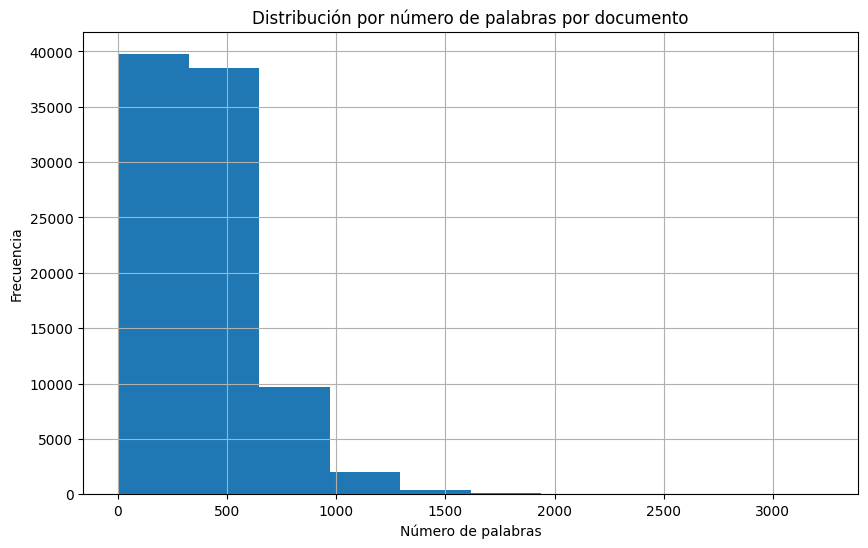

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
df.document.apply(lambda text: len(text.split(' '))).hist(ax=ax)
ax.set_title("Distribución por número de palabras por documento")
ax.set_xlabel("Número de palabras")
ax.set_ylabel("Frecuencia")
plt.show()

## Partiendo los documentos

Los modelos de lenguaje tienden a tener un tamaño de contexto limitado y muchas veces no podemos volcar documentos enteros en el contexto bien sea porque simplemente no caben o porque les estaría restando espacio a otros documentos que podrían ser relevantes. Por eso, es necesario partir los documentos en "chunks" de tal forma que al momento de hacer la búsqueda de documentos, no solo los documentos obtenidos quepan en el contexto del LLM, sino que pueda haber algo de diversidad.

Hay diferentes estrategias para partir los documentos, una de ellas, como los autores del paper original de RAG, es partir los documentos por una cantidad de palabras fijas, e incluso podemos permitirnos que haya un solapamiento entre los documentos una vez partidos con el fin de que haya oportunidad de recuperar un contexto más global cuando la información relevante se expande por varias oraciones en el documento.

In [6]:
from typing import Callable, Dict, List, Optional
from collections import defaultdict


def split_text(chunk_size: int, sliding_window: int = 0) -> Callable:
    """split_text

    Retorna una función a aplicar sobre un dataset de hf que:
    1. Separará cada documento en pedazos de tamaño chunk_size
    2. Creará documentos solapados entre si para un mismo original,
       dependiendo del sliding_window especificado. Es decir:

       - sliding_window = 0: No habrá solapamiento, cada sub-documento
       estará uno inmediatamente seguido del final del otro.

       - sliding_window > 0: Habrá solapamiento de todo el documento
       excepto por la cantidad de palabras en el sliding_window
    """
    def _split_text(batch):
        # juntamos el resumen y el documento, partiendolos por palabras.
        # Esto ya que el resumen suele contener parte del texto del articulo, entonces sirve para evitar pérdidas de información.
        articles = {url: summary.split(' ') + document.split(' ') for url, summary, document in zip(batch['url'], batch['summary'], batch['document'])}
        chunks = defaultdict(list)

        # procedemos a iterar cada articulo para crear un nuevo dataset de documentos
        for title, (url, doc_words) in zip(batch['title'], articles.items()):
            # mantenemos un buffer para almacenar sub-documentos del tamaño de chunk
            buffer = []
            for word in doc_words:
                # llenamos el buffer hasta que sea igual o superior al chunk size esperado
                if len(buffer) < chunk_size:
                    buffer.append(word)
                else:
                    # Cuando el buffer se llena, creamos un nuevo documento para el mismo titulo
                    chunk_text = ' '.join(buffer)
                    # guardamos titulo y url para usarlos como referencia después.
                    chunks['title'].append(title)
                    chunks['text'].append(chunk_text)
                    chunks['url'].append(url)
                    # nos desplazamos hacia adelante tanto como hayamos definido el
                    # sliding window, esto permite el solapamiento del documento
                    if sliding_window == 0:
                        del buffer[:]
                    else:
                        del buffer[0: sliding_window]
                    buffer.append(word)
            # si el buffer aún tiene información, creamos un nuevo documento para no perder información
            if buffer:
                chunk_text = ' '.join(buffer)
                chunks['title'].append(title)
                chunks['text'].append(chunk_text)
                chunks['url'].append(url)

        return chunks
    return _split_text

# Creamos chunks de 100 paralbras ya que se considera una buena medida segun el paper original y la frecuencia de palabras por documento observada anteriormente
# Se establece un sliding_window de 50, lo cual quiere decir que los sub-documentos de un mismo documento original compartiran la mitad entre si.
documents = dataset.map(split_text(chunk_size=100, sliding_window=50), batched=True, remove_columns=dataset.column_names)
documents

Map:   0%|          | 0/90528 [00:00<?, ? examples/s]

Dataset({
    features: ['title', 'url', 'text'],
    num_rows: 734449
})

Vemos que el dataset ha aumentado de tamañó, esto es esperado ya que hemos partido cada documento en pedazos de a 100. Ahora observemos algunos ejemplares:

In [7]:
documents[0:2500:250]

,title,url,text
0,¿Cómo cultivar Delphinium?,https://es.wikihow.com/cultivar-delphinium,"Cuando llegue marzo o abril, escoge brotes nuevos cerca de la base de la planta. Haz el corte ce..."
1,¿Cómo hacer Una batería casera?,https://es.wikihow.com/hacer-una-bater%C3%ADa-casera,Reúne los materiales. Llena un vaso de plástico con agua a 3/4 de su capacidad. Agrega 1 cuchara...
2,¿Cómo colocar Los espejos según el feng shui?,https://es.wikihow.com/colocar-los-espejos-seg%C3%BAn-el-Feng-Shui,es muy malo para el feng shui de tu hogar. Evita utilizar espejos redondeados u ovalados en tu h...
3,¿Cómo dividir Una planta flox?,https://es.wikihow.com/dividir-una-planta-flox,"de debilidad o sobrepoblación antes de dividirla. Como regla de dedo, permite que el racimo de l..."
4,¿Cómo seguir Los requerimientos nutricionales para la anemia?,https://es.wikihow.com/seguir-los-requerimientos-nutricionales-para-la-anemia,están en un riesgo elevado de sufrir de anemia y estos son: las mujeres (a causa de la pérdida ...
5,¿Cómo compartir Una carpeta en la red?,https://es.wikihow.com/compartir-una-carpeta-en-la-red,en esta carpeta. Esto también le otorga a este usuario la capacidad para cambiar los permisos en...
6,¿Cómo preparar Vermicompost?,https://es.wikihow.com/preparar-vermicompost,"los granos de café también servirán. Es importante en especial que no agregues carne, huesos ni..."
7,¿Cómo curar El daño del reflujo gástrico?,https://es.wikihow.com/evitar-que-tu-gato-engorde-y-se-vuelva-perezoso,"de la constitución, tamaño, raza y sexo de tu mascota. Tal vez quieras comprar una taza medidora..."
8,¿Cómo rellenar Tu sostén?,https://es.wikihow.com/colocar-letreros-de-Prohibido-el-Paso,señalización permanezca legible con el tiempo. Tu área puede tener requisitos específicos sobre ...
9,"¿Cómo teñirte El cabello con té, café o especias?",https://es.wikihow.com/preparar-un-blanqueador-de-dientes,de la superficie de los dientes. Puedes aplicarlo como blanqueador de diversos modos: Introduce...


In [8]:
documents.reset_format()

## Creando el vector store

El vector store es la "base de datos" a la que el modelo puede acceder para recuperar documentos relevantes a una petición que se le haga al chatbot y que podrá utilizar como contexto para generar una respuesta. Este vector store es en si los embeddings de los documentos que hemos generado anteriormente.

Para el encoder, utilizaremos un modelo pre-entrenado [Multilingual E5](https://huggingface.co/intfloat/multilingual-e5-small), que es un modelo de lenguaje multi-idiomas que utiliza arquitecturas de transformers, similar a BERT y GPT. El propósito de esta parte es simplemente construir un vector store de la que podamos recuperar documentos relevantes en función de la entrada del usuario, tal cual, por lo que la recuperación de documentos en si, no estará conectada con el proceso de predicción de tokens. Esto es una diferencia clave con el paper original ya que en este último si que se entrena un modelo de recuperación de documentos. Pero ya que vamos a utilizar otro LLM el cual no podemos manipular, simplemente podemos conectarlos a través de sus entradas y salidas.

In [9]:
import os
from pathlib import Path
import numpy as np
from sentence_transformers import SentenceTransformer

# model_ckpt = 'intfloat/multilingual-e5-small'
model_ckpt = 'intfloat/multilingual-e5-large'
embeddings_path = Path('data/vectorstore.npy')
# limitamos el tamaño del store para hacer más rápido el ejercicio, incrementar para mejores resultados.
limit = 5000
subset = documents.take(limit)

model = SentenceTransformer(model_ckpt)

if embeddings_path.exists():
    vectorstore = np.load(str(embeddings_path))
else:
    vectorstore = subset.map(lambda example: {'embedding': model.encode(example['text'])}, remove_columns=subset.column_names)
    vectorstore.reset_format()
    vectorstore = np.concatenate([np.array(v['embedding'], dtype=np.float32).reshape(1, -1) for v in vectorstore.to_iterable_dataset()], axis=0)
    os.makedirs(embeddings_path.parent, exist_ok=True)
    np.save(str(embeddings_path), vectorstore)


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [10]:
vectorstore.shape

(5000, 1024)

In [11]:
subset.reset_format()

## Creando el `DocumentRetriever`

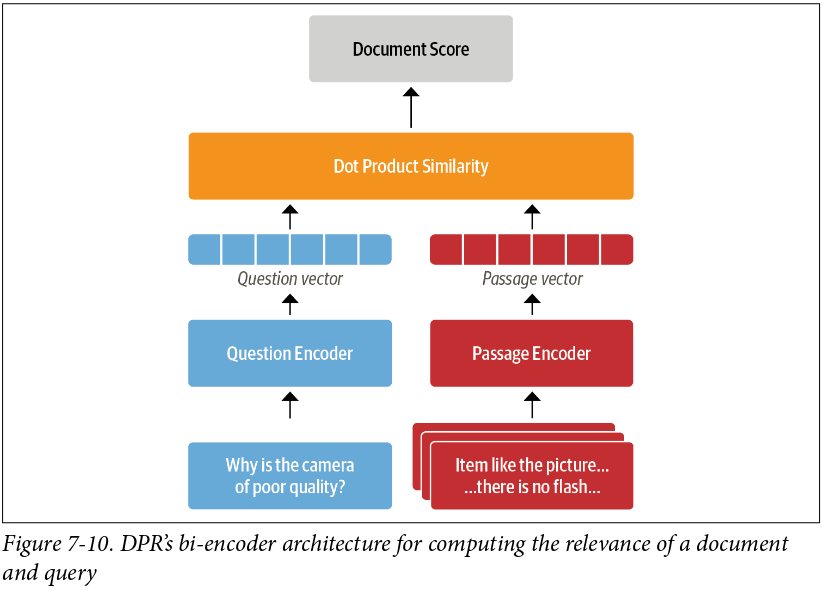

El document retriever es la porción del modelo que va a encontrar aquellos documentos con una gran relevancia con la entrada del usuario. Esta operación, lo que hace es calcular la similitud entre dos textos, el query y los documentos, ambos proyectados en el espacio denso de los embeddings según el modelo que estemos usando. Recordemos que los embeddings semanticamente similares tienden a estar cercanos el uno del otro, por tanto, debería tener sentido obtener los documentos similares en función del producto punto entre el query y los documentos. Esto es justamente lo que hace el Document Retriever. Esto puede ser una red entrenable, justamente para mejorar la calidad de las representaciones de los embeddings y asi obtener mejores similitudes entre queries y documentos.

En esta implementación, como utilizarémos más adelante un LLM externo el cual tiene sus propios codificadores, lo mejor es recuperar los documentos como texto y no como embeddings, de lo contrario podemos obtener resultados inesperados.

In [12]:
from datasets import Dataset
from sentence_transformers import util as st_util

class DocumentRetriever:

    def __init__(self, documents: Dataset, vectorstore: np.ndarray, model: SentenceTransformer) -> None:
        self.documents = documents
        self.vectorstore = vectorstore
        self.model = model

    def search(self, query: str, k: int = 5):
        # el query debe ser proyectado en el espacio del embedding para poder operar contra el vector store, generado con el mismo encoder.
        q = self.model.encode(query)
        # calculamos el dot product similarity entre ambos
        scores = st_util.dot_score(q, self.vectorstore)
        scores = scores.squeeze()

        # ordenamos por el mayor logit y obtenemos el topk
        topk = (-scores).argsort()[:k].numpy().tolist()

        # retornamos los documentos (texto real) de los documentos topk
        return [{**self.documents[i], "score": scores[i].item()} for i in topk]

Ahora observemos unos resultados. Recordemos uno de los articulos que obtuvimos anteriormente tras pre-procesar el dataset y pongamos a prueba el retriever.

In [13]:
retriever = DocumentRetriever(subset, vectorstore, model)
retriever.search('Qué es feng shui?', k = 5)

[{'title': '¿Cómo colocar Los espejos según el feng shui?',
  'url': 'https://es.wikihow.com/colocar-los-espejos-seg%C3%BAn-el-Feng-Shui',
  'text': 'es muy malo para el feng shui de tu hogar. Evita utilizar espejos redondeados u ovalados en tu hogar. Por lo general, los espejos cuadrados o rectangulares se consideran mejores para crear un buen feng shui. No cuelgues espejos rotos o rajados en tu hogar. Si un espejo que tienes en tu hogar se rompe, tíralo inmediatamente.',
  'score': 0.8175098896026611},
 {'title': '¿Cómo colocar Los espejos según el feng shui?',
  'url': 'https://es.wikihow.com/colocar-los-espejos-seg%C3%BAn-el-Feng-Shui',
  'text': 'pero evita aquellos que son pequeños o facetados. Lo aconsejable es poder verte de pies a cabeza. Evita escoger espejos con superficies distorsionadas. Esto también aplica a los espejos con superficies anticuadas. Se cree que observar a través de estos espejos hace que las personas se sientan distorsionadas, y esto es muy malo para el fen

Vemos que por lo menos dentro de los resultados hemos recuperado el articulo sobre feng shui, lo cual nos indica que el retriever si podría entregarnos resultados relevantes.

## Implementando el LLM

Ahora, vamos a implementar la clase que hará interface entre el modelo LLM que utilizaremos (Llama 3) y el resto de la aplicación.

In [14]:
from abc import abstractmethod
from typing import Any, Generator

class LLM:

    @abstractmethod
    def completion_stream(self, *args: Any, **kwargs: Any) -> Generator:
        raise NotImplementedError


    def completion(self, *args, **kwargs):
        return "".join(self.completion_stream(*args, **kwargs))



In [15]:
from typing import Any, Generator
import ollama
import time

class Ollama(LLM):

    def __init__(self, model: str) -> None:
        super().__init__()
        self.model = model

    def completion_stream(self, messages) -> Generator[Any, None, None]:
        stream = ollama.chat(
            model=self.model,
            messages=messages,
            stream=True
        )
        for chunk in stream:
            content = chunk["message"]["content"]
            token = content if content is not None else ""
            yield token

Instalamos ollama si ya no lo está.

In [16]:
!if ! type ollama > /dev/null; then curl -fsSL https://ollama.com/install.sh | sh; else echo "Ollama ya está instalado."; fi

/bin/bash: line 1: type: ollama: not found
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> NVIDIA GPU installed.
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


#### ATENCIÓN!
Si estás corriendo el notebook en Colab, descomenta las líneas de la siguiente celda y cuando cargue la terminal, ejecuta el commando `ollama serve &`

In [26]:
#%load_ext colabxterm
#%xterm

Descargamos el modelo llama3

In [18]:
!ollama pull llama3

Y creamos una instancia del modelo.

In [19]:
llm_ollama = Ollama(model="llama3")

Recordemos que el modelo que se utilizó para el encoding (multilingual E5) es muy diferente al modelo de chat que aquí vamos a usar (llama3), razón por la cual la recuperación de documentos la hemos implementado de forma que entrega texto y no embeddings. Entonces, la forma como vamos a hacer interface con llama 3 es mediante prompts cuidadosamente organizados, incluyendo el contexto en texto plano según la conversación y los documentos recuperados. Es por esto que se preparan unas plantillas de conversación, pero estas plantillas son de cara a llama 3, con el que el usuario no va a hablar directamente. Le pediremos a llama 3 que responda a un texto que le pasarémos combinando el texto que hemos recuperado.

In [20]:
document_separator = "\n\n"

# Este es el prompt que le enviaremos a llama3 para que genere la respuesta.
# 'context' contendrá el texto de los documentos recuperados y la conversación con el usuario que tengamos de nuestro aldo
# 'question' será la última preguna hecha por el usuario.
question_template = """Utiliza los siguientes fragmentos de contexto para responder la pregunta al final.
Si no sabes la respuesta, di que no lo sabes.
No menciones que te he proporcionado fragmentos, simula que ya tenías esta información en tu conocimiento y responde como en una conversación natural.

{context}

Pregunta: {question}
Respuesta Útil"""

# Este es otro prompt que se utilizará para generar una pregunta resumida con el historial de chat que el usuario lleve hasta el momento.
history_remplate = """Dada la siguiente conversación y la pregunta, expresa de otro modo la pregunta para que todo sea una sola pregunta en general

Historial:
{chat_history}
Siguiente pregunta: {question}
Pregunta general:"""

### Definición del Chatbot

Finalmente implementaremos la clase que combinará todos los componentes. Esta clase es la que se encarga de recibir las peticiones e invocar cada componente según corresponda, esto es:

1. Recibir el query del usuario
2. Utilizar el document retriever para recuperar documentos relevantes a la pregunta
3. Construir un prompt para llama 3 con el **texto** de la pregunta y los documentos encontrados.
4. Interactuar con llama 3 para recuperar sus respuestas y almacenarlas en el historial.
5. Identificar los documentos relevantes para el contexto y construir citas de referencia.

In [21]:
class ChatBot:

    def __init__(self, document_retriever: DocumentRetriever, llm: LLM, topk: int = 5) -> None:
        self.dr = document_retriever
        self.llm = llm
        self.topk = topk
        self.history = []

    def reset(self):
        del self.history[:]

    def follow_up_query(self, question):
        prompt = history_remplate.format(chat_history="\n".join(self.history), question=question)
        query = self.llm.completion(prompt)
        return query

    def __call__(self, question: str, history: bool = False):
        if history and len(self.history):
            query = self.follow_up_query(question)
        else:
            query = question

        documents = self.dr.search(query, k = self.topk)

        contexts = [document['text'] for document in documents]
        context = document_separator.join(contexts)
        prompt = question_template.format(context=context, question=query)

        messages = [{'role': 'system', 'content': prompt}]

        answer = self.llm.completion(messages)

        if history:
            self.history.append('\n'.join([f'Pregunta: {prompt}', f'Respuesta: {answer}']))

        citation = {document['title']: document['url'] for document in documents}
        citation = [f"{idx}. {title} - {url}" for idx, (title, url) in enumerate(citation.items(), 1)]
        return '\n'.join([answer, *citation])


Pongamos a prueba el chatbot, hagámos la misma pregunta que hemos hecho antes al document retriever.

In [22]:
chatbot = ChatBot(retriever, llm_ollama)

In [23]:
print(chatbot("¿Qué es el feng shui?"))

El feng shui se refiere a la creación de un buen ambiente energético en tu hogar mediante la elección de objetos y decoraciones que armonizan con la energía natural. En este sentido, se recomienda evitar el uso de espejos redondeados o ovalados, así como aquellos con superficies distorsionadas o anticuadas, ya que pueden afectar negativamente el feng shui de tu hogar. Es mejor optar por espejos cuadrados o rectangulares y asegurarte de que no estén rotos o rajados.
1. ¿Cómo colocar Los espejos según el feng shui? - https://es.wikihow.com/colocar-los-espejos-seg%C3%BAn-el-Feng-Shui
2. ¿Cómo tratar Las erupciones que producen los hongos? - https://es.wikihow.com/dejar-de-desperdiciar-en-tu-vida
3. ¿Cómo reparar Una tecla de computadora portátil? - https://es.wikihow.com/convertirse-en-un-alquimista
4. ¿Cómo lograr Tener paz interior? - https://es.wikihow.com/lograr-tener-paz-interior


Vemos que responde coherentemente y ha citado el articulo donde justamente se hace mención al feng sui, proveniente de nuestro vector store.

### Usando Gradio para crear una interfaz de chat

In [24]:
import gradio as gr

with gr.Blocks() as gr_blocks:
    chatbot = gr.Chatbot()
    bot = ChatBot(retriever, llm_ollama)
    msg = gr.Textbox(
        label="Sobre qué quieres conversar?",
        placeholder="Ház tu pregunta aquí y presiona enter."
    )
    clear = gr.Button("Limpiar")

    def respond(question, chat_history):
        bot_message = bot(question)
        chat_history.append((question, bot_message))
        return "", chat_history

    def reset_chat():
        bot.reset()
        return ""

    msg.submit(respond, [msg, chatbot], [msg, chatbot])
    clear.click(reset_chat, None, chatbot, queue=False)

gr_blocks.launch(inline=False)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2af537e1de2814a6f8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


#### Atención!
Abre el enlace que te entrega la celda de arriba en una pestaña aparte y disfruta!

In [25]:
gr_blocks.close()

Closing server running on port: 7860


## Conclusiones

- Los modelos de lenguaje tienden a ser estáticos, su conocimiento se limita a el corpus con los cuales fueron entrenados o hecho fine tuning. Esto presenta una limitante al momento de requerir información más actualizada puesto que el modelo no cuenta con mecanismos "rápidos" para hacerlo por si solo. Re-entrenar el modelo puede resultar costoso o inviable en algunos casos.
- RAG es una popular técnica para dotar a estos modelos de cierto dinamismo y acceso a información más reciente que puede que no haya sido parte de su proceso de entrenamiento. El trabajo del modelo base es entonces el de generar secuencias coherentes de forma condicionada a un contexto que le estamos proveyendo a través de los documentos relevantes recuperados.
- El hecho de poder separar la recuperación de la generación hace que sea mucho más factible la actualización de información del agente conversacional, ya no sería tan necesario re-entrenar el modelo base en si, sino el modelo de recuperación de documentos y/o su respectivo codificador. Esta es una tarea de significativo menor esfuerzo que re-entrenar el modelo base para muchos casos.
- RAG no es perfecto, lo que estamos haciendo aquí es simplemente condicionar al modelo un poco más de lo que normalmente lo estaría, estos agentes realmnete NO están razonando ni planificando nada, simplemente estamos influyendo en las probabilidades del siguiente token de las secuencias que se generan. Además, si tenemos un buen retriever pero un mal modelo base, los resultados que podemos obtener no van a ser tan buenos de igual modo.
- Esta implementación, si bien funciona relativamente bien, no entrena un Document Retriever, por lo que las similitudes de documentos y queries podrían ser mejores, dando lugar a una mejor calidad de resultado conversacional.
- Asimismo, en cuanto a los datos, cada escenario puede ser diferente y merezca ser atentido de forma particular, por ejemplo la partición de documentos puede seguir estrategias diferentes, como un chunk size mayor o menor, con o sin solapamiento. Estos hyper-parámetros tienen un efecto en la calidad de los resultados del modelo y deben ser explorados en función del caso de uso.